---
title: "World Happiness Report"
subtitle: "Happiness Trends and Contributing Factors (2011-2024)"
author: "C. Dervieux"
date: "2025-09-30"
format: 
  html: default
  typst: default
---

In [1]:
import polars as pl
import numpy as np
from plotnine import *
from great_tables import GT

# Read CSV with polars
whr_pl = pl.read_csv("data/whr.csv")

theme_whr = (
  theme_minimal()
  + theme(
    plot_subtitle=element_text(size=12),
    plot_title=element_text(size=14)
  ) 
)

## Introduction

This report analyzes the data from the 2025 World Happiness Report, which looks at global happiness trends and factors that contribute to national happiness levels from 2011 to 2024. The dataset contains happiness rankings and scores for 169 countries.

## Global Happiness Trends

### Overall Trends (2011-2024)

In [2]:
global_trends = (
    whr_pl
    .group_by('year')
    .agg([
        pl.col('ladder_score').mean().alias('mean_happiness'),
        pl.col('ladder_score').median().alias('median_happiness'),
        pl.col('ladder_score').min().alias('min_happiness'),
        pl.col('ladder_score').max().alias('max_happiness'),
        pl.col('ladder_score').count().alias('countries_count')
    ])
    .sort('year')
)

numeric_cols = ['mean_happiness', 'median_happiness', 'min_happiness', 'max_happiness']
global_trends = global_trends.with_columns([
    pl.col(col).round(3) for col in numeric_cols
])

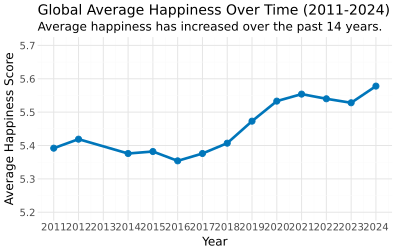

In [3]:
global_plot = (
    ggplot(global_trends, aes(x='year', y='mean_happiness')) 
    + geom_line(size=1.5, color='#0076BA')  # Using a nice blue color
    + geom_point(size=3, color='#0076BA')
    + scale_x_continuous(breaks=range(2011, 2025, 1)) 
    + scale_y_continuous(limits=(5.2, 5.7), breaks=np.arange(5.2, 5.8, 0.1))
    + theme_whr
    + theme(
        axis_title=element_text(size=12),
        axis_text=element_text(size=10)
    ) 
    + labs(
        title="Global Average Happiness Over Time (2011-2024)",
        subtitle="Average happiness has increased over the past 14 years.",
        x="Year",
        y="Average Happiness Score"
    ) 
)

global_plot

#### Key findings

- **Gradual Improvement**: Average global happiness has increased from ~5.39 (2011) to ~5.58 (2024)
- **2011-2016**: Relatively stable around 5.35-5.40
- **2017-2019**: Beginning of upward trend
- **2019-2024**: Higher plateau around 5.50-5.58

## Country-Level Analysis

### Countries with Largest Changes in Happiness

In [4]:
country_stats = (
    whr_pl
    .drop_nulls(['year', 'ladder_score'])
    .sort(['country_name', 'year'])
    .group_by('country_name')
    .agg([
        pl.col('year').min().alias('first_year'),
        pl.col('year').max().alias('last_year'),
        pl.col('ladder_score').first().alias('first_score'),
        pl.col('ladder_score').last().alias('last_score')
    ])
)

most_changed_countries = country_stats.with_columns([
    (pl.col('last_score') - pl.col('first_score')).alias('change'),
    (pl.col('last_year') - pl.col('first_year')).alias('years_span')
])

most_changed_countries = most_changed_countries.filter(pl.col('years_span') >= 10)

most_changed_countries = most_changed_countries.with_columns([
    (pl.col('change') > 0).alias('improvement'),
    pl.col('change').abs().alias('abs_change')
])

improvements = (
    most_changed_countries
    .filter(pl.col('improvement'))
    .sort('abs_change', descending=True)
    .head(5)
)

declines = (
    most_changed_countries
    .filter(~pl.col('improvement'))
    .sort('abs_change', descending=True)
    .head(5)
)

improvements_df = (
    whr_pl
    .join(
        improvements.select('country_name'),
        on='country_name',
        how='inner'
    )
)

declines_df = (
    whr_pl
    .join(
        declines.select('country_name'),
        on='country_name',
        how='inner'
    )
)

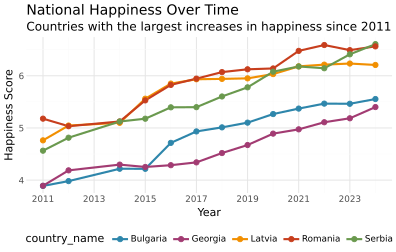

In [5]:
improvements_plot = (
    ggplot(improvements_df, aes(x="year", y="ladder_score", color="country_name"))
    + geom_line(size=1.2)
    + geom_point(size=2.5)
    + scale_x_continuous(breaks=range(2011, 2025, 2))
    + scale_color_manual(
        values=["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#6A994E"],
        name=""
    )
    + theme_whr
    + theme(
        legend_position="bottom",
        legend_direction="horizontal"
    )
    + labs(
        title="National Happiness Over Time",
        subtitle="Countries with the largest increases in happiness since 2011",
        x="Year",
        y="Happiness Score"
    )
)

improvements_plot

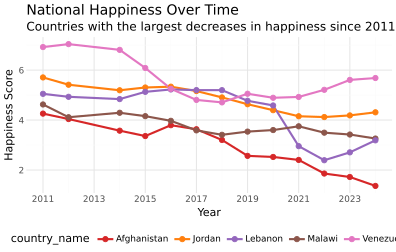

In [6]:
declines_plot = (
    ggplot(declines_df, aes(x="year", y="ladder_score", color="country_name"))
    + geom_line(size=1.2)
    + geom_point(size=2.5)
    + scale_x_continuous(breaks=range(2011, 2025, 2))
    + scale_color_manual(
        values=["#D62728", "#FF7F0E", "#9467BD", "#8C564B", "#E377C2"],
        name=""
    )
    + theme_whr
    + theme(
        legend_position="bottom",
        legend_direction="horizontal"
    )
    + labs(
        title="National Happiness Over Time",
        subtitle="Countries with the largest decreases in happiness since 2011",
        x="Year",
        y="Happiness Score"
    )
)

declines_plot

#### Key findings

- Post-Soviet and eastern European countries showed improvement trends, with Serbia, Bulgaria, and Georgia having the largest improvements in happiness.
- Afghanistan, Lebanon, and Jordan had the most severe declines in happiness, coinciding with major political and economic events. 

## Happiness Contributing Factors

### Contributing factors 2024

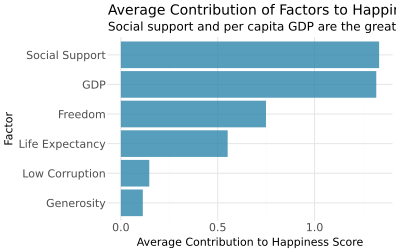

In [7]:
latest_year = 2024
factor_data_2024 = whr_pl.filter(pl.col('year') == latest_year)

factor_contributions = pl.DataFrame({
    'Factor': ['GDP', 'Social Support', 'Life Expectancy', 'Freedom', 'Generosity', 'Low Corruption'],
    'Average_Contribution': [
        factor_data_2024.filter(pl.col('explained_by_log_gdp_per_capita') != "NA")
            .select(pl.col('explained_by_log_gdp_per_capita').cast(pl.Float64).mean())
            .item(),
        factor_data_2024.filter(pl.col('explained_by_social_support') != "NA")
            .select(pl.col('explained_by_social_support').cast(pl.Float64).mean())
            .item(),
        factor_data_2024.filter(pl.col('explained_by_healthy_life_expectancy') != "NA")
            .select(pl.col('explained_by_healthy_life_expectancy').cast(pl.Float64).mean())
            .item(),
        factor_data_2024.filter(pl.col('explained_by_freedom_to_make_life_choices') != "NA")
            .select(pl.col('explained_by_freedom_to_make_life_choices').cast(pl.Float64).mean())
            .item(),
        factor_data_2024.filter(pl.col('explained_by_generosity') != "NA")
            .select(pl.col('explained_by_generosity').cast(pl.Float64).mean())
            .item(),
        factor_data_2024.filter(pl.col('explained_by_perceptions_of_corruption') != "NA")
            .select(pl.col('explained_by_perceptions_of_corruption').cast(pl.Float64).mean())
            .item()
    ]
}).sort('Average_Contribution', descending=True)

factor_plot = (
    ggplot(
        factor_contributions, 
        aes(x='reorder(Factor, Average_Contribution)', y='Average_Contribution')
    )
    + geom_col(alpha=0.8, fill='#2E86AB')
    + coord_flip()
    + labs(
        title="Average Contribution of Factors to Happiness",
        subtitle="Social support and per capita GDP are the greatest contributors",
        x="Factor",
        y="Average Contribution to Happiness Score"
    ) 
    + theme_whr
    + theme(
        axis_text=element_text(size=11)
    )
)

factor_plot

The top contributors to happiness worldwide in 2024 were social support, GDP per capita, and having a sense of freedom. 

### Happiness Factor Breakdown for Top 10 Countries (2024)

In [8]:
latest_sorted = (
    whr_pl
    .filter(pl.col('year') == latest_year)
    .sort('ladder_score', descending=True)
)

top_10_countries = (
    latest_sorted
    .head(10)
    .select(['country_name', 'ladder_score'])
    .with_columns(pl.col('ladder_score').round(3))
)

bottom_10_countries = (
    latest_sorted
    .tail(10)
    .reverse()  # Reverse to show worst first
    .select(['country_name', 'ladder_score'])
    .with_columns(pl.col('ladder_score').round(3))
)

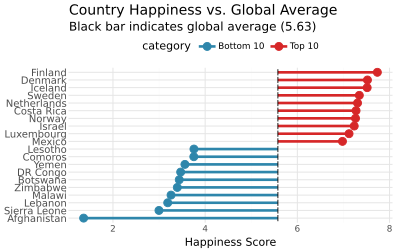

In [9]:
top_with_category = top_10_countries.with_columns(
    pl.lit("Top 10").alias("category")
)
bottom_with_category = bottom_10_countries.with_columns(
    pl.lit("Bottom 10").alias("category")
)

all_countries = pl.concat([top_with_category, bottom_with_category])

global_mean_2024 = whr_pl.filter(pl.col('year') == 2024)['ladder_score'].mean()

dumbbell_data = all_countries.with_columns([
    pl.lit(global_mean_2024).alias('global_avg')
])

dumbbell_plot = (
    ggplot(dumbbell_data)
    + geom_segment(
        aes(x='reorder(country_name, ladder_score)', xend='reorder(country_name, ladder_score)',
            y='global_avg', yend='ladder_score', color='category'),
        size=1.5
    )
    + geom_point(
        aes(x='reorder(country_name, ladder_score)', y='ladder_score', color='category'),
        size=4
    )
    + geom_point(
        aes(x='reorder(country_name, ladder_score)', y='global_avg'),
        color='black', shape='|', size=3
    )
    + coord_flip()
    + scale_color_manual(
        values=["#2E86AB", "#D62728"],
        name=""
    )
    + theme_whr
    + theme(
        axis_text_y=element_text(size=10),
        legend_position='top'
    )
    + labs(
        title="Country Happiness vs. Global Average",
        subtitle="Black bar indicates global average (5.63)",
        x="",
        y="Happiness Score"
    )
)

dumbbell_plot

In [10]:
top_countries_2024 = (
    whr_pl
    .filter(pl.col('year') == 2024)
    .sort('ladder_score', descending=True)
    .head(10)
    .select(['rank', 'country_name', 'ladder_score', 'explained_by_log_gdp_per_capita', 
             'explained_by_social_support', 'explained_by_healthy_life_expectancy'])
    # Convert string columns to numeric
    .with_columns([
        pl.col('explained_by_log_gdp_per_capita').cast(pl.Float64),
        pl.col('explained_by_social_support').cast(pl.Float64),
        pl.col('explained_by_healthy_life_expectancy').cast(pl.Float64)
    ])
)

gt_top10 = (
    GT(top_countries_2024)
    .tab_header(
        title="Top 10 happiest countries in 2024",
        subtitle="Based on the World Happiness Report ladder scores"
    )
    .cols_label(
        rank="Rank",
        country_name="Country",
        ladder_score="Happiness Score",
        explained_by_log_gdp_per_capita="GDP per Capita",
        explained_by_social_support="Social Support",
        explained_by_healthy_life_expectancy="Healthy Life"
    )
    .fmt_number(
        columns=['ladder_score', 'explained_by_log_gdp_per_capita', 
                 'explained_by_social_support', 'explained_by_healthy_life_expectancy'],
        decimals=3
    )
    .data_color(
        columns=['ladder_score'],
        palette="Blues",
        domain=[7, 8]
    )
    .tab_source_note(
        source_note="Source: World Happiness Report 2025"
    )
    .opt_stylize(style=1, color='blue')
    .opt_horizontal_padding(scale=1.5)
)

gt_top10

GT(_tbl_data=shape: (10, 6)
┌──────┬──────────────┬──────────────┬────────────────────┬────────────────────┬───────────────────┐
│ rank ┆ country_name ┆ ladder_score ┆ explained_by_log_g ┆ explained_by_socia ┆ explained_by_heal │
│ ---  ┆ ---          ┆ ---          ┆ dp_per_capit…      ┆ l_support          ┆ thy_life_expe…    │
│ i64  ┆ str          ┆ f64          ┆ ---                ┆ ---                ┆ ---               │
│      ┆              ┆              ┆ f64                ┆ f64                ┆ f64               │
╞══════╪══════════════╪══════════════╪════════════════════╪════════════════════╪═══════════════════╡
│ 1    ┆ Finland      ┆ 7.736        ┆ 1.749              ┆ 1.783              ┆ 0.824             │
│ 2    ┆ Denmark      ┆ 7.521        ┆ 1.825              ┆ 1.748              ┆ 0.82              │
│ 3    ┆ Iceland      ┆ 7.515        ┆ 1.799              ┆ 1.84               ┆ 0.873             │
│ 4    ┆ Sweden       ┆ 7.345        ┆ 1.783              ┆ 1.698              ┆ 0.889             │
│ 5    ┆ Netherlands  ┆ 7.306        ┆ 1.822              ┆ 1.667              ┆ 0.844             │
│ 6    ┆ Costa Rica   ┆ 7.274        ┆ 1.492              ┆ 1.6                ┆ 0.68              │
│ 7    ┆ Norway       ┆ 7.262        ┆ 1.902              ┆ 1.711              ┆ 0.863             │
│ 8    ┆ Israel       ┆ 7.234        ┆ 1.695              ┆ 1.743              ┆ 0.824             │
│ 9    ┆ Luxembourg   ┆ 7.122        ┆ 2.028              ┆ 1.558              ┆ 0.864             │
│ 10   ┆ Mexico       ┆ 6.979        ┆ 1.435              ┆ 1.504              ┆ 0.55              │
└──────┴──────────────┴──────────────┴────────────────────┴────────────────────┴───────────────────┘, _body=<great_tables._gt_data.Body object at 0x000001900E4F42F0>, _boxhead=Boxhead([ColInfo(var='rank', type=<ColInfoTypeEnum.default: 1>, column_label='Rank', column_align='right', column_width=None), ColInfo(var='country_name', type=<ColInfoTypeEnum.default: 1>, column_label='Country', column_align='left', column_width=None), ColInfo(var='ladder_score', type=<ColInfoTypeEnum.default: 1>, column_label='Happiness Score', column_align='right', column_width=None), ColInfo(var='explained_by_log_gdp_per_capita', type=<ColInfoTypeEnum.default: 1>, column_label='GDP per Capita', column_align='right', column_width=None), ColInfo(var='explained_by_social_support', type=<ColInfoTypeEnum.default: 1>, column_label='Social Support', column_align='right', column_width=None), ColInfo(var='explained_by_healthy_life_expectancy', type=<ColInfoTypeEnum.default: 1>, column_label='Healthy Life', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001900E4F4050>, _spanners=Spanners([]), _heading=Heading(title='Top 10 happiest countries in 2024', subtitle='Based on the World Happiness Report ladder scores', preheader=None), _stubhead=None, _source_notes=['Source: World Happiness Report 2025'], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='ladder_score', rows=[0], mask=None), grpname=None, colname='ladder_score', rownum=0, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#2575b7')]), StyleInfo(locname=LocBody(columns='ladder_score', rows=[1], mask=None), grpname=None, colname='ladder_score', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#64a9d3')]), StyleInfo(locname=LocBody(columns='ladder_score', rows=[2], mask=None), grpname=None, colname='ladder_score', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellSty

#### Patterns Among Top Countries

- **Nordic countries tend to be happy**: Finland, Denmark, Iceland, Sweden, and Norway show similar balanced patterns.
- **Effect of GDP varies**: Luxembourg has the highest GDP contribution, while Costa Rica has high happiness with lower GDP contribution, but strong social factors.
- **Balanced Approach**: No single happiness factor dominates. 

## Country Spotlight: 2020 vs 2024

In [11]:
selected_countries = ['Finland', 'France', 'United States', 'Japan', 'Brazil']

country_comparison = (
    whr_pl
    .filter(pl.col('year').is_in([2020, 2024]))
    .filter(pl.col('country_name').is_in(selected_countries))
    .select(['country_name', 'year', 'ladder_score'])
    .pivot(values='ladder_score', index='country_name', on='year')
)

country_comparison = country_comparison.with_columns([
    ((pl.col('2024') - pl.col('2020')) / pl.col('2020') * 100).alias('pct_change')
]).sort('2024', descending=True)

gt_country_comparison = (
    GT(country_comparison)
    .tab_header(
        title="Country Happiness Trends",
        subtitle="Comparing happiness scores between 2020 and 2024"
    )
    .cols_label(
        country_name="Country"
    )
    .fmt_number(
        columns=['2024', '2020'],
        decimals=3
    )
    .fmt_percent(
        columns=['pct_change'],
        decimals=1,
        scale_values=False
    )
    .tab_spanner(
        label="Happiness Score",
        columns=['2020', '2024']
    )
    .data_color(
        columns=['pct_change'],
        palette=['#ef553b', '#ffffff', '#3b82f6'],
        domain=[-5, 5]
    )
    .opt_stylize(style=3, color='cyan')
)

gt_country_comparison

GT(_tbl_data=shape: (5, 4)
┌───────────────┬───────┬───────┬────────────┐
│ country_name  ┆ 2024  ┆ 2020  ┆ pct_change │
│ ---           ┆ ---   ┆ ---   ┆ ---        │
│ str           ┆ f64   ┆ f64   ┆ f64        │
╞═══════════════╪═══════╪═══════╪════════════╡
│ Finland       ┆ 7.736 ┆ 7.842 ┆ -1.351696  │
│ United States ┆ 6.724 ┆ 6.951 ┆ -3.265717  │
│ France        ┆ 6.593 ┆ 6.69  ┆ -1.449925  │
│ Brazil        ┆ 6.494 ┆ 6.33  ┆ 2.590837   │
│ Japan         ┆ 6.147 ┆ 5.94  ┆ 3.484848   │
└───────────────┴───────┴───────┴────────────┘, _body=<great_tables._gt_data.Body object at 0x000001900E639480>, _boxhead=Boxhead([ColInfo(var='country_name', type=<ColInfoTypeEnum.default: 1>, column_label='Country', column_align='left', column_width=None), ColInfo(var='2020', type=<ColInfoTypeEnum.default: 1>, column_label='2020', column_align='right', column_width=None), ColInfo(var='2024', type=<ColInfoTypeEnum.default: 1>, column_label='2024', column_align='right', column_width=None), ColInfo(var='pct_change', type=<ColInfoTypeEnum.default: 1>, column_label='pct_change', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001900E719A90>, _spanners=Spanners([SpannerInfo(spanner_id='Happiness Score', spanner_level=0, spanner_label='Happiness Score', spanner_units=None, spanner_pattern=None, vars=['2020', '2024'], built=None)]), _heading=Heading(title='Country Happiness Trends', subtitle='Comparing happiness scores between 2020 and 2024', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='pct_change', rows=[0], mask=None), grpname=None, colname='pct_change', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fbd1ca')]), StyleInfo(locname=LocBody(columns='pct_change', rows=[1], mask=None), grpname=None, colname='pct_change', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f5907f')]), StyleInfo(locname=LocBody(columns='pct_change', rows=[2], mask=None), grpname=None, colname='pct_change', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#facec6')]), StyleInfo(locname=LocBody(columns='pct_change', rows=[3], mask=None), grpname=None, colname='pct_change', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#99befa')]), StyleInfo(locname=LocBody(columns='pct_change', rows=[4], mask=None), grpname=None, colname='pct_change', rownum=4, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#76a8f9')])], _locale=<great_tables._gt_data.Locale object at 0x000001900E719F90>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000001900E71A210>, <great_tables._gt_data.FormatInfo object at 0x000001900E71A5D0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), 

## Detailed Country Profiles

In [12]:
countries_detail = ['Finland', 'United States', 'Brazil', 'Japan', 'France']

country_profiles = (
    whr_pl
    .filter(pl.col('country_name').is_in(countries_detail))
    .group_by('country_name')
    .agg([
        pl.col('ladder_score').filter(pl.col('year') == 2024).first().alias('score_2024'),
        pl.col('rank').filter(pl.col('year') == 2024).first().alias('rank_2024'),
        pl.col('ladder_score').min().alias('min_score'),
        pl.col('ladder_score').max().alias('max_score'),
        pl.col('ladder_score').mean().alias('avg_score'),
        pl.col('ladder_score').alias('score_history')
    ])
    .sort('rank_2024')
)

country_profiles_stats = country_profiles.with_columns([
    (pl.col('score_2024') - pl.col('avg_score')).alias('change_from_mean'),
    ((pl.col('max_score') - pl.col('min_score'))).alias('range')
])

gt_profiles_stats = (
    GT(country_profiles_stats)
    .tab_header(
        title="Comparative Analysis of National Happiness Indices",
        subtitle="Temporal patterns and current status (World Happiness Report, 2011-2024)"
    )
    .cols_label(
        country_name="Nation",
        score_2024="Score",
        rank_2024="Rank", 
        avg_score="M",
        change_from_mean="Δ",
        range="Range"
    )
    .cols_hide(['score_history', 'min_score', 'max_score'])
    .fmt_number(
        columns=['score_2024', 'avg_score', 'range'],
        decimals=2
    )
    .fmt_number(
        columns=['change_from_mean'],
        decimals=2,
        force_sign=True
    )
    .tab_spanner(
        label="2024",
        columns=['score_2024', 'rank_2024']
    )
    .tab_spanner(
        label="Historical (2011-2024)",
        columns=['avg_score', 'change_from_mean', 'range']
    )
    .data_color(
        columns=['change_from_mean'],
        palette=['#d73027', '#fee08b', '#1a9850'],
        domain=[-0.5, 0.5]
    )
    .cols_width({
        'country_name': '25%',
        'score_2024': '12%',
        'rank_2024': '10%',
        'avg_score': '12%',
        'change_from_mean': '10%',
        'range': '12%'
    })
    .tab_source_note(
        source_note="Note: M = mean; Δ = change from historical mean; Range = max−min across all years. All scores on 0-10 scale."
    )
    .opt_stylize(style=3, color='gray')
    .opt_horizontal_padding(scale=1.1)
)

gt_profiles_stats

GT(_tbl_data=shape: (5, 9)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
│ country_na ┆ score_2024 ┆ rank_2024 ┆ min_score ┆ … ┆ avg_score ┆ score_his ┆ change_fr ┆ range  │
│ me         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ tory      ┆ om_mean   ┆ ---    │
│ ---        ┆ f64        ┆ i64       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ f64    │
│ str        ┆            ┆           ┆           ┆   ┆           ┆ list[f64] ┆ f64       ┆        │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ Finland    ┆ 7.736      ┆ 1         ┆ 7.389     ┆ … ┆ 7.6469    ┆ [7.736,   ┆ 0.0891    ┆ 0.453  │
│            ┆            ┆           ┆           ┆   ┆           ┆ 7.741, …  ┆           ┆        │
│            ┆            ┆           ┆           ┆   ┆           ┆ 7.579]    ┆           ┆        │
│ United     ┆ 6.724      ┆ 24        ┆ 6.724     ┆ … ┆ 6.965892  ┆ [6.724,   ┆ -0.241892 ┆ 0.546  │
│ States     ┆            ┆           ┆           ┆   ┆           ┆ 6.725, …  ┆           ┆        │
│            ┆            ┆           ┆           ┆   ┆           ┆ 7.27]     ┆           ┆        │
│ France     ┆ 6.593      ┆ 33        ┆ 6.442     ┆ … ┆ 6.6146    ┆ [6.593,   ┆ -0.0216   ┆ 0.322  │
│            ┆            ┆           ┆           ┆   ┆           ┆ 6.609, …  ┆           ┆        │
│            ┆            ┆           ┆           ┆   ┆           ┆ 6.746]    ┆           ┆        │
│ Brazil     ┆ 6.494      ┆ 36        ┆ 6.125     ┆ … ┆ 6.517277  ┆ [6.272,   ┆ -0.023277 ┆ 0.858  │
│            ┆            ┆           ┆           ┆   ┆           ┆ 6.125, …  ┆           ┆        │
│            ┆            ┆           ┆           ┆   ┆           ┆ 6.494]    ┆           ┆        │
│ Japan      ┆ 6.147      ┆ 55        ┆ 5.8708    ┆ … ┆ 5.995215  ┆ [6.147,   ┆ 0.151785  ┆ 0.2762 │
│            ┆            ┆           ┆           ┆   ┆           ┆ 6.06, …   ┆           ┆        │
│            ┆            ┆           ┆           ┆   ┆           ┆ 6.059]    ┆           ┆        │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴────────┘, _body=<great_tables._gt_data.Body object at 0x000001900C1CFF00>, _boxhead=Boxhead([ColInfo(var='country_name', type=<ColInfoTypeEnum.default: 1>, column_label='Nation', column_align='left', column_width='25%'), ColInfo(var='score_2024', type=<ColInfoTypeEnum.default: 1>, column_label='Score', column_align='right', column_width='12%'), ColInfo(var='rank_2024', type=<ColInfoTypeEnum.default: 1>, column_label='Rank', column_align='right', column_width='10%'), ColInfo(var='min_score', type=<ColInfoTypeEnum.hidden: 4>, column_label='min_score', column_align='right', column_width=None), ColInfo(var='max_score', type=<ColInfoTypeEnum.hidden: 4>, column_label='max_score', column_align='right', column_width=None), ColInfo(var='avg_score', type=<ColInfoTypeEnum.default: 1>, column_label='M', column_align='right', column_width='12%'), ColInfo(var='change_from_mean', type=<ColInfoTypeEnum.default: 1>, column_label='Δ', column_align='right', column_width='10%'), ColInfo(var='range', type=<ColInfoTypeEnum.default: 1>, column_label='Range', column_align='right', column_width='12%'), ColInfo(var='score_history', type=<ColInfoTypeEnum.hidden: 4>, column_label='score_history', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001900E71AE90>, _spanners=Spanners([SpannerInfo(spanner_id='2024', spanner_level=0, spanner_label='2024', spanner_units=None, spanner_pattern=None, vars=['score_2024', 'rank_2024'], built=None), SpannerInfo(spanner_id='Historical (2011-2024)', spanner_level=0, spanner_label='Historical (2011-2024)', spanner_units=None, spanner_pattern=None, vars=['avg_score', 'change_from_mean', 'range'], built=None)]), _heading=Heading(title='Comparative Analysis of National Happiness Indi



## Conclusions

1. **Global happiness is gradually improving**: The world has become slightly happier over the past decade.

2. **Social connections and economic conditions are most important**: GDP per capita and social support are the strongest contributors to national happiness. 

3. **Multiple pathways to happiness**: The top countries show that there are different combinations of factors that can lead to high happiness levels.

5. **Crises can severely affect happiness**: Countries experiencing political upheaval or economic crisis show dramatic happiness declines.